## **IMPORT STATEMENTS**

In [ ]:
import keras
from keras.models import Sequential
import tensorflow as tf
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import os
import cv2
import time
import random
from numpy import *

# **IMPORTING PRE-PROCESSED IMAGE ARRAYS**

In [ ]:
image_features_x=np.load('/content/drive/MyDrive/processed-data/image_features_x.npy')

In [ ]:
image_features_y=np.load('/content/drive/MyDrive/processed-data/image_features_y.npy')

### APPLYING SpecAugment 

In [ ]:
split = train_test_split(image_features_x, image_features_y, test_size=0.1, random_state=42)
(x_train, x_test, y_train_num, y_test_num) = split

In [ ]:
del image_features_x
del image_features_y

### Check array shapes

In [ ]:
print((x_train.shape,y_train_num.shape))
print((x_test.shape,y_test_num.shape))

((6325, 277, 277, 3), (6325,))
((1117, 277, 277, 3), (1117,))


## **CONVERTING LABELS TO CATEGORICAL DATA**

### current label is an integer from range 0 to 5, representing the index in the array SENTIMENTS. We need an array of length 6 to represent the output layer in the Neural Network

the array has 1 to represent it's class in the SENTIMENTS array, and 0 for the rest.

example: 

if current class_id = 2, 

then modified y_label will be [0. 0. 1. 0. 0. 0.]



In [ ]:
#Since we have 6 classes we should expect the shape [1] of y_train, y_val and y_test to change from 1 to 6
y_train = np_utils.to_categorical(y_train_num)
y_test = np_utils.to_categorical(y_test_num)

In [ ]:
del y_train_num
del y_test_num

In [ ]:
#Verifying the dimension after one hot encoding
print((x_train.shape,y_train.shape))
print((x_test.shape,y_test.shape))

((6325, 277, 277, 3), (6325, 6))
((1117, 277, 277, 3), (1117, 6))


## LEARNING RATE ANNEALER
The **learning rate annealer** decreases the learning rate after a certain number of epochs if the error rate does not change. Here, through this technique, we will monitor the validation accuracy and if it seems to be a plateau in 3 epochs, it will reduce the learning rate by 0.01.

Refer: https://analyticsindiamag.com/how-to-use-learning-rate-annealing-with-neural-networks/


In [ ]:
#Learning Rate Annealer
lrr= ReduceLROnPlateau(monitor='val_accuracy', factor=.01, patience=5, min_lr=1e-9) 

## **ALEX-NET MODEL IMPLEMENTATION**

In [ ]:
#Instantiation
AlexNet = Sequential()

#1st Convolutional Layer
AlexNet.add(Conv2D(filters=96, input_shape=(277,277,3), kernel_size=(11,11), strides=(4,4), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same'))

#2nd Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same'))

#3rd Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#4th Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#5th Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same'))

#Passing it to a Fully Connected layer
AlexNet.add(Flatten())
# 1st Fully Connected Layer
AlexNet.add(Dense(4096, input_shape=(277,277,3,)))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
# Add Dropout to prevent overfitting
AlexNet.add(Dropout(0.5))

#2nd Fully Connected Layer
AlexNet.add(Dense(4096))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.5))

#3rd Fully Connected Layer
AlexNet.add(Dense(1000))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.4))

#Output Layer
AlexNet.add(Dense(6))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('softmax'))

## **COMPILE THE MODEL**

In [ ]:
AlexNet.compile(loss = keras.losses.categorical_crossentropy, optimizer= 'adam', metrics=['accuracy'])
AlexNet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 70, 70, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 70, 70, 96)       384       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 70, 70, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 35, 35, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 35, 35, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 35, 35, 256)      1

### **VIEW THE LAYERS OF THE MODEL**

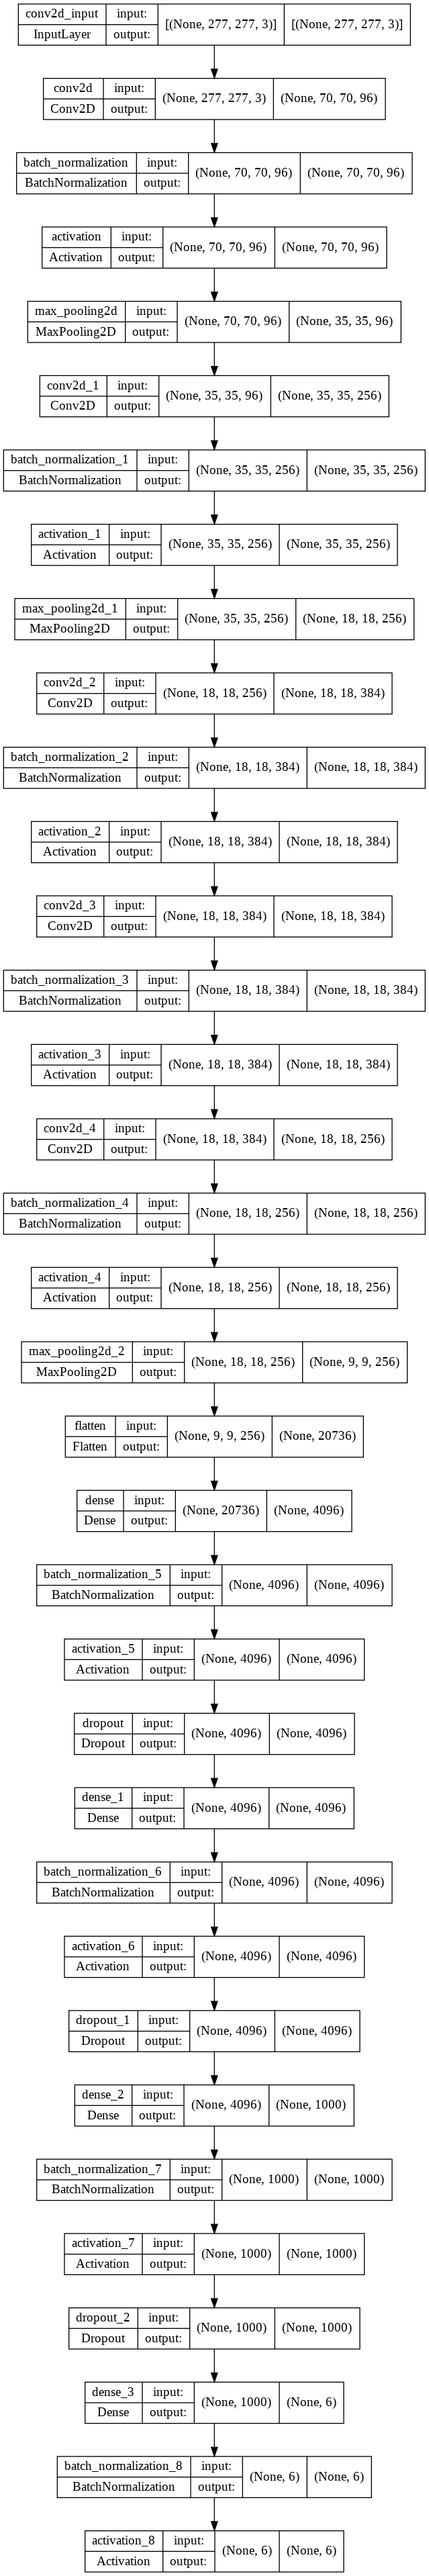

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(AlexNet, "AlexNet.png", show_shapes=True)

## **TRAIN THE NETWORK**

Training the custom AlexNet network is very simple with the Keras module enabled through TensorFlow. We call the fit() method and pass relevant arguments.

In [ ]:
#Defining the parameters
batch_size = 32
epochs = 60
learn_rate = .001

In [ ]:
#Training the model
AlexNet.fit(
    x_train, 
    y_train, 
    batch_size=batch_size,
    epochs = epochs,
    steps_per_epoch = x_train.shape[0]//batch_size, 
    validation_split=0.1,
    # validation_data = (x_val, y_val), 
    # validation_steps = x_val.shape[0]//batch_size, 
    callbacks = [lrr], 
    verbose=1
  )

Epoch 1/100
197/197 [==============================] - 32s 97ms/step - loss: 1.4088 - accuracy: 0.4451 - val_loss: 3.2795 - val_accuracy: 0.1738 - lr: 0.0010
Epoch 2/100
197/197 [==============================] - 17s 86ms/step - loss: 1.2551 - accuracy: 0.5163 - val_loss: 3.1796 - val_accuracy: 0.2401 - lr: 0.0010
Epoch 3/100
197/197 [==============================] - 17s 86ms/step - loss: 1.1591 - accuracy: 0.5621 - val_loss: 1.3616 - val_accuracy: 0.5118 - lr: 0.0010
Epoch 4/100
197/197 [==============================] - 17s 87ms/step - loss: 1.1142 - accuracy: 0.5798 - val_loss: 1.2468 - val_accuracy: 0.5671 - lr: 0.0010
Epoch 5/100
197/197 [==============================] - 17s 87ms/step - loss: 1.0383 - accuracy: 0.6137 - val_loss: 2.1037 - val_accuracy: 0.3412 - lr: 0.0010
Epoch 6/100
197/197 [==============================] - 17s 88ms/step - loss: 0.9976 - accuracy: 0.6348 - val_loss: 2.6996 - val_accuracy: 0.2259 - lr: 0.0010
Epoch 7/100
197/197 [==============================]

In [ ]:
# Saving the model
AlexNet.save('alexnetmodel_without_aug.h5')

In [ ]:
!cp alexnetmodel_without_aug.h5 "/content/drive/MyDrive/project-models/"

## **VISUALIZING THE MODEL**

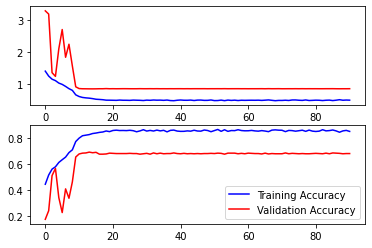

In [ ]:
f,ax=plt.subplots(2,1) #Creates 2 subplots under 1 column

#Assigning the first subplot to graph training loss and validation loss
ax[0].plot(AlexNet.history.history['loss'],color='b',label='Training Loss')
ax[0].plot(AlexNet.history.history['val_loss'],color='r',label='Validation Loss')

#Plotting the training accuracy and validation accuracy
ax[1].plot(AlexNet.history.history['accuracy'],color='b',label='Training Accuracy')
ax[1].plot(AlexNet.history.history['val_accuracy'],color='r',label='Validation Accuracy')

plt.legend()

## **EVALUATING THE MODEL**

In [ ]:
results = AlexNet.evaluate(x_test, y_test, batch_size=32)
print("test loss, test accuracy:", results)

35/35 [==============================] - 2s 44ms/step - loss: 0.9727 - accuracy: 0.6500
test loss, test accuracy: [0.9726904630661011, 0.6499552130699158]


## **MAKING PREDICTIONS**

In [ ]:
predictions = AlexNet.predict(x_test)
print("predictions shape:", predictions.shape)

predictions shape: (1117, 6)


## **PLOTTING CONFUSION MATRIX**
We will see the classification performance using a non-normalized and a normalized confusion matrices. For this purpose, first, we will define a function through which the confusion matrices will be plotted.

In [ ]:
#Defining function for confusion matrix plot
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # Print Confusion matrix
    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [ ]:
np.set_printoptions(precision=2)

We need the y_test and y_pred to be in a one-dimensional array

In [ ]:
y_true=np.argmax(y_test,axis=1)
y_pred=np.argmax(predictions, axis=1)

In [ ]:
confusion_mtx=confusion_matrix(y_true, y_pred)

class_names= ['ANGER','DISGUST','FEAR','HAPPY','NEUTRAL','SAD']

Confusion matrix, without normalization


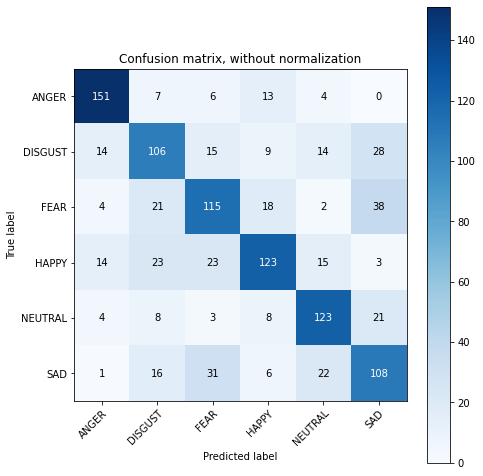

In [ ]:
# Plotting non-normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes = class_names,title = 'Confusion matrix, without normalization')

Normalized confusion matrix


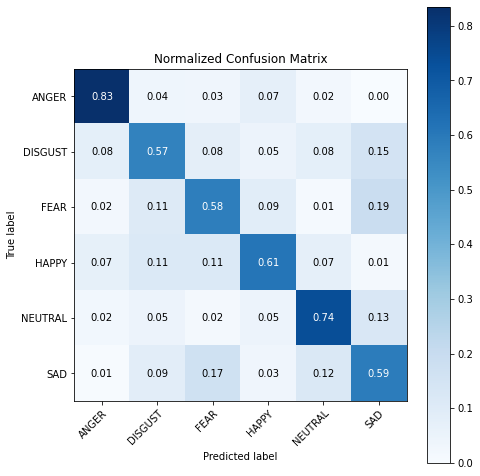

In [ ]:
# Plotting Normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes = class_names, normalize=True, title = 'Normalized Confusion Matrix')